# 0. Loading the data and setting the scene 

In [1]:
!pip -q install linearmodels

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import nan_euclidean_distances
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# 패널 회귀
from linearmodels.panel import PanelOLS
import statsmodels.api as sm
import statsmodels.formula.api as smf
import re

In [3]:
# archive 폴더 안의 파일 읽기
df = pd.read_csv("/Users/yujin.sophia.kim/Desktop/data/WDI/archive/WDI_Indicators_MainData.csv")

# 데이터 확인
print(df.info())
print(f"\nSize of the Data: {df.shape}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 95 columns):
 #   Column                                                                                                                                        Non-Null Count  Dtype  
---  ------                                                                                                                                        --------------  -----  
 0   Time                                                                                                                                          209 non-null    int64  
 1   Time Code                                                                                                                                     209 non-null    object 
 2   Country Name                                                                                                                                  209 non-null    object 
 3   Country Code                       

In [4]:
df.describe()


,Time,"Current education expenditure, primary (% of total expenditure in primary public institutions) [SE.XPD.CPRM.ZS]","Current education expenditure, secondary (% of total expenditure in secondary public institutions) [SE.XPD.CSEC.ZS]","Current education expenditure, tertiary (% of total expenditure in tertiary public institutions) [SE.XPD.CTER.ZS]","Current education expenditure, total (% of total expenditure in public institutions) [SE.XPD.CTOT.ZS]",Current health expenditure (% of GDP) [SH.XPD.CHEX.GD.ZS],Domestic general government health expenditure (% of GDP) [SH.XPD.GHED.GD.ZS],"Educational attainment, at least Bachelor's or equivalent, population 25+, female (%) (cumulative) [SE.TER.CUAT.BA.FE.ZS]","Educational attainment, at least Bachelor's or equivalent, population 25+, male (%) (cumulative) [SE.TER.CUAT.BA.MA.ZS]","Educational attainment, at least Bachelor's or equivalent, population 25+, total (%) (cumulative) [SE.TER.CUAT.BA.ZS]",...,"Unemployment, total (% of total labor force) (modeled ILO estimate) [SL.UEM.TOTL.ZS]","Unemployment, youth female (% of female labor force ages 15-24) (modeled ILO estimate) [SL.UEM.1524.FE.ZS]","Unemployment, youth male (% of male labor force ages 15-24) (modeled ILO estimate) [SL.UEM.1524.MA.ZS]","Unemployment, youth total (% of total labor force ages 15-24) (modeled ILO estimate) [SL.UEM.1524.ZS]","Vulnerable employment, female (% of female employment) (modeled ILO estimate) [SL.EMP.VULN.FE.ZS]","Vulnerable employment, male (% of male employment) (modeled ILO estimate) [SL.EMP.VULN.MA.ZS]","Vulnerable employment, total (% of total employment) (modeled ILO estimate) [SL.EMP.VULN.ZS]","Wage and salaried workers, female (% of female employment) (modeled ILO estimate) [SL.EMP.WORK.FE.ZS]","Wage and salaried workers, male (% of male employment) (modeled ILO estimate) [SL.EMP.WORK.MA.ZS]","Wage and salaried workers, total (% of total employment) (modeled ILO estimate) [SL.EMP.WORK.ZS]"
count,209.00000,160.000000,155.000000,155.000000,164.000000,209.000000,209.000000,181.000000,181.000000,182.000000,...,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000
mean,2016.00000,91.038883,92.163499,90.938089,91.710226,10.224090,7.321458,24.489600,24.446647,24.503965,...,6.619746,15.091091,16.073507,15.513435,7.869830,10.876624,9.475974,89.892182,83.842524,86.609187
std,3.16987,5.105092,4.406583,4.241498,3.991709,2.360894,1.913369,11.694871,12.018839,11.442790,...,3.920827,10.148095,9.892808,9.961708,4.172952,4.716494,4.385335,4.875040,5.910130,5.362777
min,2011.00000,69.931122,77.698563,70.385498,73.767067,3.335964,2.113965,0.262423,0.282064,0.271797,...,1.640000,3.182000,4.130000,3.668000,0.221089,0.313090,0.296355,73.044964,70.327326,71.601655
25%,2013.00000,87.947254,89.071793,88.795101,89.509956,9.380000,6.650000,18.829885,19.000000,19.868821,...,4.296000,8.757000,9.359000,8.743000,4.489211,8.057614,6.498467,87.711808,81.052217,84.298487
50%,2016.00000,91.136391,92.295937,90.971687,92.420471,10.379509,7.830000,26.912407,26.130039,27.828066,...,5.674000,11.241000,12.834000,12.147000,7.813703,10.971947,9.591485,90.099424,82.741007,86.156497
75%,2019.00000,94.732161,96.332344,93.670300,94.663853,10.970000,8.630000,32.669998,32.310001,31.912340,...,7.830000,18.546000,20.763000,19.934000,9.430590,13.516962,11.580701,93.954204,87.977852,90.076253
max,2021.00000,99.483620,99.503937,98.103500,97.966171,18.756220,10.692574,48.680000,48.639999,47.290001,...,26.094000,54.565000,56.204000,55.444000,23.795179,21.190954,22.220932,98.749044,96.776959,97.149776


# 1. Data Cleaning and Processing

- https://www.kaggle.com/code/parsabahramsari/wdi-data-cleaning-and-knn-imputation

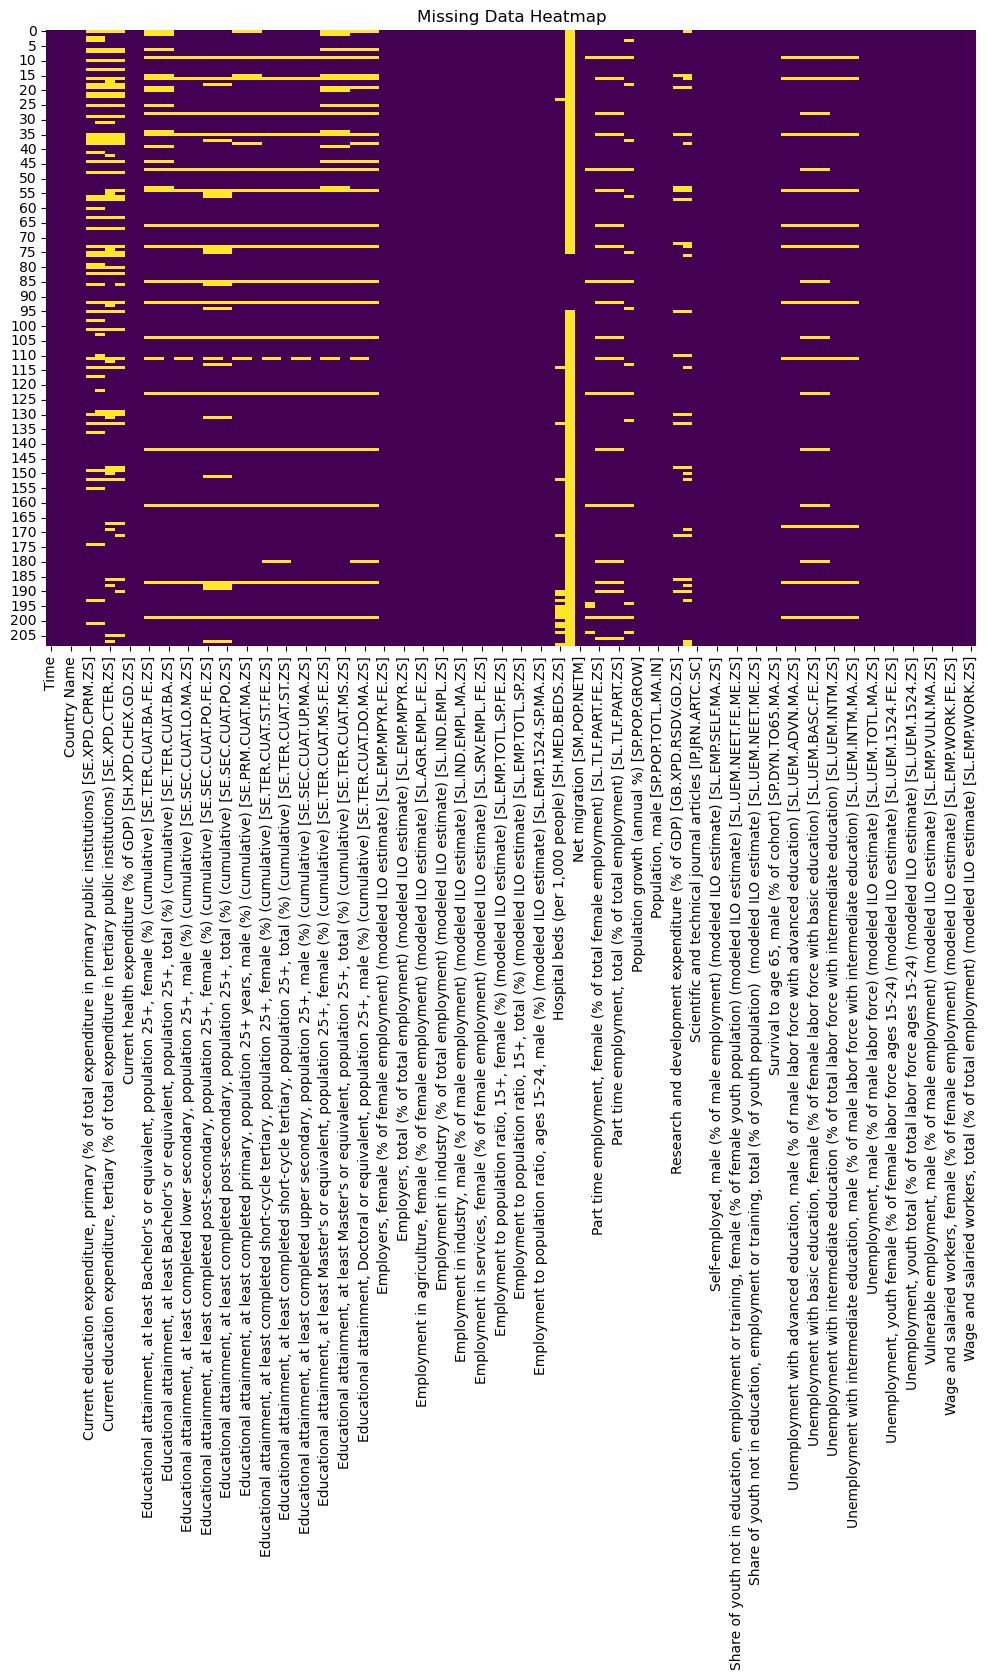

In [5]:
plt.figure(figsize=(12,8))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Data Heatmap")
plt.show()

In [6]:
print(f'Duplicates before removal: {df.duplicated().sum()}')
df.drop_duplicates(inplace=True)
print(f'Duplicates after removal: {df.duplicated().sum()}')

Duplicates before removal: 0
Duplicates after removal: 0


In [7]:
# Check missing percentage
missing_pct = df.isnull().mean() * 100

# Drop columns with >25% missing values
cols_to_drop = missing_pct[missing_pct > 25].index
df.drop(columns=cols_to_drop, inplace=True)

print(f"Dropped columns: {list(cols_to_drop)}")

Dropped columns: ['Current education expenditure, secondary (% of total expenditure in secondary public institutions) [SE.XPD.CSEC.ZS]', 'Current education expenditure, tertiary (% of total expenditure in tertiary public institutions) [SE.XPD.CTER.ZS]', 'International migrant stock (% of population) [SM.POP.TOTL.ZS]']


In [8]:
def comparative_country_time_imputation(df, target_col, country_col='Country Name', time_col='Time'):
    df_imputed = df.copy()
    
    # Pivot data to [Country x Year] matrix
    pivot_df = df_imputed.pivot(index=country_col, columns=time_col, values=target_col)
    countries = pivot_df.index
    years = pivot_df.columns

    for country in countries:
        for year in years:
            if np.isnan(pivot_df.loc[country, year]):
                # Country comparative analysis
                target_country_vector = pivot_df.loc[country].values.reshape(1, -1)
                other_countries = pivot_df.drop(country)
                country_distances = nan_euclidean_distances(target_country_vector, other_countries.values)[0]
                country_similarity_idx = np.argsort(country_distances)

                # Year comparative analysis
                target_year_vector = pivot_df[year].values.reshape(1, -1)
                other_years = pivot_df.drop(columns=year)
                year_distances = nan_euclidean_distances(target_year_vector, other_years.values.T)[0]
                year_similarity_idx = np.argsort(year_distances)

                # Select top similar countries and years clearly
                top_similar_countries = other_countries.iloc[country_similarity_idx[:5]]
                top_similar_years = other_years.iloc[:, year_similarity_idx[:5]]

                # Gather neighbor values
                country_based_values = top_similar_countries[year].dropna().values
                year_based_values = top_similar_years.loc[country].dropna().values

                # Combine these two clearly for robust imputation
                combined_values = np.concatenate([country_based_values, year_based_values])

                # Impute with average of combined values or zero if none found
                if combined_values.size > 0:
                    imputed_value = np.mean(combined_values)
                else:
                    imputed_value = 0  # Default to 0 clearly if no data available

                pivot_df.loc[country, year] = imputed_value

    # Map back to original dataframe explicitly
    for country in countries:
        for year in years:
            df_imputed.loc[
                (df_imputed[country_col] == country) & 
                (df_imputed[time_col] == year), target_col
            ] = pivot_df.loc[country, year]

    return df_imputed

In [9]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns[4:]

for col in numeric_cols:
    df = comparative_country_time_imputation(df, col)

# Verify explicitly no missing values remain
print("Remaining NaNs after advanced imputation:", df[numeric_cols].isnull().sum().sum())

Remaining NaNs after advanced imputation: 0


(209, 92)


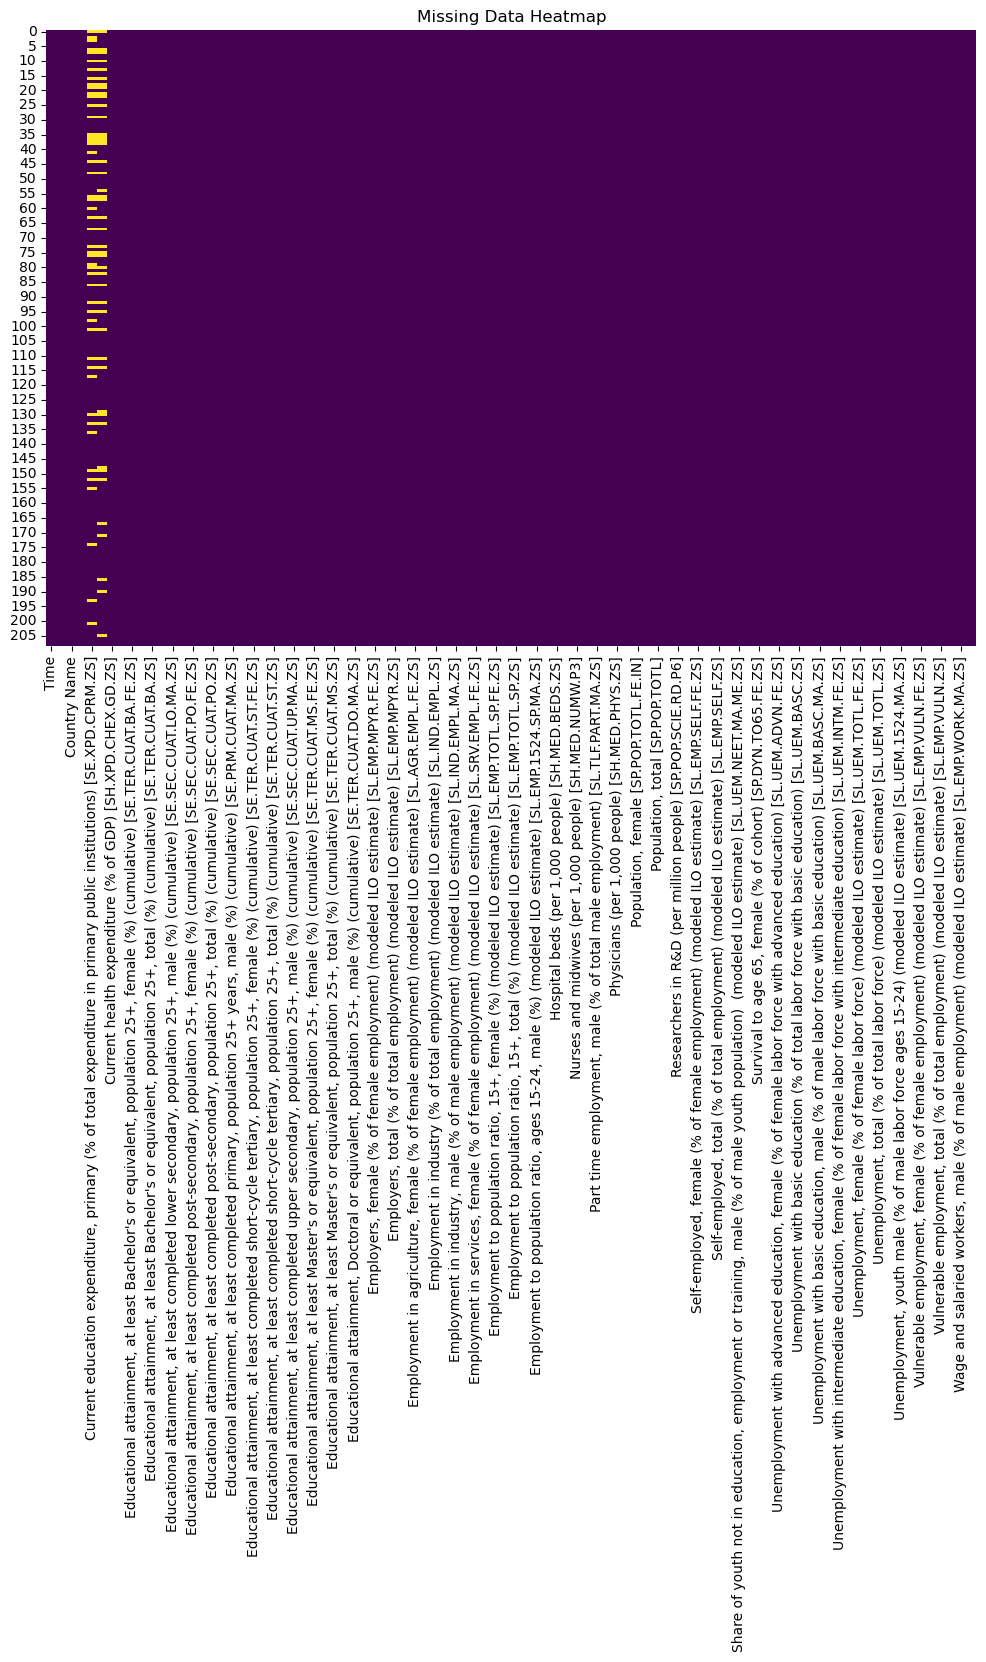

In [10]:
print(df.shape)
plt.figure(figsize=(12,8))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Data Heatmap")
plt.show()

In [11]:
# Generate country code mapping explicitly
country_mapping = {country: code for code, country in enumerate(sorted(df['Country Name'].unique()), 1)}
country_code_df = pd.DataFrame(country_mapping.items(), columns=['Country Name', 'Country Code']).sort_values('Country Code')
print(country_code_df.to_string(index=False))

# Replace country names with numeric codes clearly
df['Country Code'] = df['Country Name'].map(country_mapping)

# Drop original country name column explicitly
df.drop(columns=['Country Name', 'Time Code'], inplace=True)

# Reorder columns explicitly to have "Time" and "Country Code" first
cols = ['Time', 'Country Code'] + [col for col in df.columns if col not in ['Time', 'Country Code']]
df = df[cols]

        Country Name  Country Code
           Australia             1
             Austria             2
             Belgium             3
              Canada             4
             Denmark             5
             Finland             6
              France             7
             Germany             8
               Italy             9
               Japan            10
         Korea, Rep.            11
         Netherlands            12
              Norway            13
               Spain            14
              Sweden            15
         Switzerland            16
United Arab Emirates            17
      United Kingdom            18
       United States            19


In [12]:
df.head()


,Time,Country Code,"Current education expenditure, primary (% of total expenditure in primary public institutions) [SE.XPD.CPRM.ZS]","Current education expenditure, total (% of total expenditure in public institutions) [SE.XPD.CTOT.ZS]",Current health expenditure (% of GDP) [SH.XPD.CHEX.GD.ZS],Domestic general government health expenditure (% of GDP) [SH.XPD.GHED.GD.ZS],"Educational attainment, at least Bachelor's or equivalent, population 25+, female (%) (cumulative) [SE.TER.CUAT.BA.FE.ZS]","Educational attainment, at least Bachelor's or equivalent, population 25+, male (%) (cumulative) [SE.TER.CUAT.BA.MA.ZS]","Educational attainment, at least Bachelor's or equivalent, population 25+, total (%) (cumulative) [SE.TER.CUAT.BA.ZS]","Educational attainment, at least completed lower secondary, population 25+, female (%) (cumulative) [SE.SEC.CUAT.LO.FE.ZS]",...,"Unemployment, total (% of total labor force) (modeled ILO estimate) [SL.UEM.TOTL.ZS]","Unemployment, youth female (% of female labor force ages 15-24) (modeled ILO estimate) [SL.UEM.1524.FE.ZS]","Unemployment, youth male (% of male labor force ages 15-24) (modeled ILO estimate) [SL.UEM.1524.MA.ZS]","Unemployment, youth total (% of total labor force ages 15-24) (modeled ILO estimate) [SL.UEM.1524.ZS]","Vulnerable employment, female (% of female employment) (modeled ILO estimate) [SL.EMP.VULN.FE.ZS]","Vulnerable employment, male (% of male employment) (modeled ILO estimate) [SL.EMP.VULN.MA.ZS]","Vulnerable employment, total (% of total employment) (modeled ILO estimate) [SL.EMP.VULN.ZS]","Wage and salaried workers, female (% of female employment) (modeled ILO estimate) [SL.EMP.WORK.FE.ZS]","Wage and salaried workers, male (% of male employment) (modeled ILO estimate) [SL.EMP.WORK.MA.ZS]","Wage and salaried workers, total (% of total employment) (modeled ILO estimate) [SL.EMP.WORK.ZS]"
0,2011,1,NaN,NaN,8.537450,6.254561,19.435627,16.702708,19.443268,93.739998,...,5.083,10.780,11.921,11.370,7.235643,11.063700,9.325963,88.887973,82.113213,85.188598
1,2011,2,98.021446,95.928642,10.030000,7.290000,6.280110,6.329326,6.705862,98.854050,...,4.637,9.261,9.095,9.173,9.541601,13.516962,11.665963,84.826191,79.864144,82.174537
2,2011,3,NaN,96.381668,10.363379,7.895000,0.306420,0.704335,0.498997,77.500000,...,7.140,18.738,18.712,18.724,9.014035,12.569989,10.958520,89.264094,82.743616,85.698534
3,2011,4,NaN,89.551270,10.379509,7.289382,24.085646,24.041842,24.064234,92.831757,...,7.637,12.038,15.715,13.915,8.629436,12.284332,10.557431,88.673547,81.064832,84.659885
4,2011,5,94.645523,96.333221,10.410000,8.740000,0.471820,0.673025,0.570325,96.480003,...,7.769,14.381,18.144,16.306,4.440911,7.642493,6.128961,94.112424,88.018992,90.899592


In [13]:
from sklearn.preprocessing import StandardScaler

# Selecting columns explicitly from the 2nd column onward (0-based indexing)
cols_to_scale = df.columns[2:]
df_normalized = df
# Initialize the StandardScaler explicitly
scaler = StandardScaler()

# Fit and transform explicitly the selected columns
df_normalized[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

# Check clearly the standardized results
df_normalized.head()

,Time,Country Code,"Current education expenditure, primary (% of total expenditure in primary public institutions) [SE.XPD.CPRM.ZS]","Current education expenditure, total (% of total expenditure in public institutions) [SE.XPD.CTOT.ZS]",Current health expenditure (% of GDP) [SH.XPD.CHEX.GD.ZS],Domestic general government health expenditure (% of GDP) [SH.XPD.GHED.GD.ZS],"Educational attainment, at least Bachelor's or equivalent, population 25+, female (%) (cumulative) [SE.TER.CUAT.BA.FE.ZS]","Educational attainment, at least Bachelor's or equivalent, population 25+, male (%) (cumulative) [SE.TER.CUAT.BA.MA.ZS]","Educational attainment, at least Bachelor's or equivalent, population 25+, total (%) (cumulative) [SE.TER.CUAT.BA.ZS]","Educational attainment, at least completed lower secondary, population 25+, female (%) (cumulative) [SE.SEC.CUAT.LO.FE.ZS]",...,"Unemployment, total (% of total labor force) (modeled ILO estimate) [SL.UEM.TOTL.ZS]","Unemployment, youth female (% of female labor force ages 15-24) (modeled ILO estimate) [SL.UEM.1524.FE.ZS]","Unemployment, youth male (% of male labor force ages 15-24) (modeled ILO estimate) [SL.UEM.1524.MA.ZS]","Unemployment, youth total (% of total labor force ages 15-24) (modeled ILO estimate) [SL.UEM.1524.ZS]","Vulnerable employment, female (% of female employment) (modeled ILO estimate) [SL.EMP.VULN.FE.ZS]","Vulnerable employment, male (% of male employment) (modeled ILO estimate) [SL.EMP.VULN.MA.ZS]","Vulnerable employment, total (% of total employment) (modeled ILO estimate) [SL.EMP.VULN.ZS]","Wage and salaried workers, female (% of female employment) (modeled ILO estimate) [SL.EMP.WORK.FE.ZS]","Wage and salaried workers, male (% of male employment) (modeled ILO estimate) [SL.EMP.WORK.MA.ZS]","Wage and salaried workers, total (% of total employment) (modeled ILO estimate) [SL.EMP.WORK.ZS]"
0,2011,1,NaN,NaN,-0.716123,-0.558940,-0.343154,-0.627431,-0.398426,0.500111,...,-0.392886,-0.425838,-0.420758,-0.416935,-0.152341,0.039759,-0.034290,-0.206485,-0.293304,-0.265534
1,2011,2,1.372059,1.060031,-0.082408,-0.016480,-1.458838,-1.498877,-1.527759,1.096170,...,-0.506910,-0.575880,-0.707106,-0.638009,0.401582,0.561154,0.500588,-1.041664,-0.674762,-0.828917
2,2011,3,NaN,1.173871,0.059140,0.300475,-1.965450,-1.971421,-2.078076,-1.392714,...,0.133008,0.360232,0.267349,0.323064,0.274854,0.359892,0.338881,-0.129147,-0.186383,-0.170218
3,2011,4,NaN,-0.542517,0.065989,-0.016804,0.051201,-0.010886,0.011282,0.394252,...,0.260072,-0.301576,-0.036326,-0.160843,0.182468,0.299182,0.247200,-0.250574,-0.471117,-0.364360
4,2011,5,0.708697,1.161697,0.078935,0.743165,-1.951423,-1.974051,-2.071752,0.819467,...,0.293819,-0.070141,0.209795,0.079752,-0.823674,-0.687353,-0.765061,0.867762,0.708359,0.801955


In [14]:
df.to_csv('WDI_Final_Processed.csv', index=False)

In [15]:
data_df = pd.read_csv('./WDI_Final_Processed.csv')


# 2. Data Analysis

## 2.1. EDA

In [16]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 90 columns):
 #   Column                                                                                                                                        Non-Null Count  Dtype  
---  ------                                                                                                                                        --------------  -----  
 0   Time                                                                                                                                          209 non-null    int64  
 1   Country Code                                                                                                                                  209 non-null    int64  
 2   Current education expenditure, primary (% of total expenditure in primary public institutions) [SE.XPD.CPRM.ZS]                               160 non-null    float64
 3   Current education expenditure, tota

In [17]:
print(df.columns.tolist())

['Time', 'Country Code', 'Current education expenditure, primary (% of total expenditure in primary public institutions) [SE.XPD.CPRM.ZS]', 'Current education expenditure, total (% of total expenditure in public institutions) [SE.XPD.CTOT.ZS]', 'Current health expenditure (% of GDP) [SH.XPD.CHEX.GD.ZS]', 'Domestic general government health expenditure (% of GDP) [SH.XPD.GHED.GD.ZS]', "Educational attainment, at least Bachelor's or equivalent, population 25+, female (%) (cumulative) [SE.TER.CUAT.BA.FE.ZS]", "Educational attainment, at least Bachelor's or equivalent, population 25+, male (%) (cumulative) [SE.TER.CUAT.BA.MA.ZS]", "Educational attainment, at least Bachelor's or equivalent, population 25+, total (%) (cumulative) [SE.TER.CUAT.BA.ZS]", 'Educational attainment, at least completed lower secondary, population 25+, female (%) (cumulative) [SE.SEC.CUAT.LO.FE.ZS]', 'Educational attainment, at least completed lower secondary, population 25+, male (%) (cumulative) [SE.SEC.CUAT.LO.MA.

In [18]:
data_df = pd.read_csv('./WDI_Final_Processed.csv')


# 1) 사용할 9개 지표 (원본 WDI 컬럼명)
cols_to_plot = [
    "Current health expenditure (% of GDP) [SH.XPD.CHEX.GD.ZS]",
    "Domestic general government health expenditure (% of GDP) [SH.XPD.GHED.GD.ZS]",
    "Vulnerable employment, total (% of total employment) (modeled ILO estimate) [SL.EMP.VULN.ZS]",
    "Unemployment, total (% of total labor force) (modeled ILO estimate) [SL.UEM.TOTL.ZS]",
    "Unemployment, youth total (% of total labor force ages 15-24) (modeled ILO estimate) [SL.UEM.1524.ZS]",
    "Wage and salaried workers, total (% of total employment) (modeled ILO estimate) [SL.EMP.WORK.ZS]",
    "Educational attainment, at least Bachelor's or equivalent, population 25+, total (%) (cumulative) [SE.TER.CUAT.BA.ZS]",
    "Share of youth not in education, employment or training, total (% of youth population)  (modeled ILO estimate) [SL.UEM.NEET.ME.ZS]",
    "Unemployment, youth female (% of female labor force ages 15-24) (modeled ILO estimate) [SL.UEM.1524.FE.ZS]"
]

# 2) (옵션) 특정 연도만 보고 싶다면 설정; 전체 보려면 None
YEAR_FILTER = None  # 예: 2019

# 3) 축약 라벨 함수 (subplot 타이틀 겹침 방지)
def short_name(c):
    cl = c.lower()
    if "current health expenditure" in cl: return "HealthExp (%GDP)"
    if "government health" in cl:         return "GovHealthExp (%GDP)"
    if "vulnerable employment" in cl:     return "VulnerableEmp (%)"
    if "wage and salaried" in cl:         return "WageWorkers (%)"
    if "unemployment, total" in cl and "youth" not in cl: return "Unemp Total (%)"
    if "unemployment, youth total" in cl: return "Youth Unemp (%)"
    if "bachelor" in cl:                  return "BA+ Attainment (%)"
    if "neet" in cl:                      return "NEET Youth (%)"
    if "youth female" in cl:              return "Youth Unemp (F) (%)"
    return re.sub(r"\s*\[[A-Z0-9\.\-]+\]\s*$", "", c).strip()

# 4) 존재하는 컬럼만 사용
existing = [c for c in cols_to_plot if c in data_df.columns]
if len(existing) == 0:
    raise ValueError("선택한 지표가 data_df에 없습니다. data_df.columns를 확인하세요.")
cols = existing

# 5) 숫자 변환 & (옵션) 연도 필터
df_num = data_df.copy()
for c in cols:
    df_num[c] = pd.to_numeric(df_num[c], errors="coerce")
if YEAR_FILTER is not None and "Time" in df_num.columns:
    df_num = df_num[df_num["Time"] == YEAR_FILTER]

# 6) 각 지표별 trace를 하나씩 만들되, 기본으로 첫 번째만 보이게
fig = go.Figure()
traces = []
for i, col in enumerate(cols):
    vals = df_num[col].dropna()
    traces.append(
        go.Histogram(
            x=vals,
            name=short_name(col),
            nbinsx=30,
            visible=True if i == 0 else False,  # 첫 번째만 보임
            hovertemplate=f"{col}<br>%{{x:.2f}} → %{{y}}<extra></extra>",
            marker_line_width=0.3
        )
    )
fig.add_traces(traces)

# 7) 드롭다운: 지표 선택 → 해당 trace만 visible=True
buttons = []
for i, col in enumerate(cols):
    visible = [False] * len(cols)
    visible[i] = True
    buttons.append(
        dict(
            label=short_name(col),
            method="update",
            args=[
                {"visible": visible},
                {"title": f"Distribution — {short_name(col)}"
                          + (f" (Year {YEAR_FILTER})" if YEAR_FILTER is not None else "")}
            ]
        )
    )

# 8) Y축 정규화(Count/Probability) & X축 스케일(Linear/Log) 토글 버튼
updatemenus = [
    dict(
        type="dropdown",
        direction="down",
        x=0.0, y=1.18,
        buttons=buttons,
        showactive=True
    ),
    dict(
        type="buttons",
        direction="right",
        x=0.55, y=1.18,
        buttons=[
            dict(label="Y: Count", method="restyle", args=[{"histnorm": ""}]),
            dict(label="Y: Probability", method="restyle", args=[{"histnorm": "probability"}]),
        ]
    ),
    dict(
        type="buttons",
        direction="right",
        x=0.83, y=1.18,
        buttons=[
            dict(label="X: Linear", method="relayout", args=[{"xaxis.type": "linear"}]),
        ]
    )
]

fig.update_layout(
    height=550, width=1000,
    title=f"Distribution — {short_name(cols[0])}"
          + (f" (Year {YEAR_FILTER})" if YEAR_FILTER is not None else ""),
    bargap=0.05,
    showlegend=False,
    updatemenus=updatemenus,
    margin=dict(l=30, r=20, t=90, b=30),
    font=dict(size=12),
    xaxis_title=short_name(cols[0]),
    yaxis_title="Count"
)

fig.show()


In [19]:
# 메타데이터와 전처리된 데이터 불러오기
metadata = pd.read_excel("/Users/yujin.sophia.kim/Desktop/data/WDI/archive/WDI_Indicators_Metadata.xlsx")
data_df = pd.read_csv('./WDI_Final_Processed.csv')


# 사용할 컬럼 정의
cols_avail = {
    "Unemployment_total": "Unemployment, total (% of total labor force) (modeled ILO estimate) [SL.UEM.TOTL.ZS]",
    "YouthUnemployment_total": "Unemployment, youth total (% of total labor force ages 15-24) (modeled ILO estimate) [SL.UEM.1524.ZS]",
    "VulnerableEmployment": "Vulnerable employment, total (% of total employment) (modeled ILO estimate) [SL.EMP.VULN.ZS]",
    "WageWorkers": "Wage and salaried workers, total (% of total employment) (modeled ILO estimate) [SL.EMP.WORK.ZS]",
    "HealthExp_GDP": "Current health expenditure (% of GDP) [SH.XPD.CHEX.GD.ZS]",
    "GovHealthExp_GDP": "Domestic general government health expenditure (% of GDP) [SH.XPD.GHED.GD.ZS]"
}

# 필요한 컬럼만 추출
df_sel = data_df[["Country Code", "Time"] + list(cols_avail.values())].copy()
df_sel = df_sel.rename(columns={v: k for k, v in cols_avail.items()})

# 숫자형 변환
for col in cols_avail.keys():
    df_sel[col] = pd.to_numeric(df_sel[col], errors="coerce")

# 국가별 평균값 계산
country_avg = df_sel.groupby("Country Code")[list(cols_avail.keys())].mean().dropna()

# 상관행렬 계산
corr_matrix = country_avg.corr()

# Plotly Heatmap
fig = px.imshow(
    corr_matrix,
    text_auto=".2f",   # 소수점 둘째 자리까지 표시
    color_continuous_scale="RdBu_r",
    zmin=-1, zmax=1,
    title="Correlation Heatmap: Employment & Health Indicators"
)

fig.update_layout(
    width=800, height=600,
    xaxis_title="Indicators",
    yaxis_title="Indicators"
)

fig.show()


## 2.2. Employment and Health Expenditure

In [20]:

# --- 데이터 로드 ---
metadata = pd.read_excel("/Users/yujin.sophia.kim/Desktop/data/WDI/archive/WDI_Indicators_Metadata.xlsx")
df = pd.read_csv("/Users/yujin.sophia.kim/Desktop/data/WDI/archive/WDI_Indicators_MainData.csv")


# --- 선택 & 리네임 ---
df = df[[
    "Country Name", "Country Code", "Time",
    "Current health expenditure (% of GDP) [SH.XPD.CHEX.GD.ZS]",
    "Domestic general government health expenditure (% of GDP) [SH.XPD.GHED.GD.ZS]",
    "Unemployment, total (% of total labor force) (modeled ILO estimate) [SL.UEM.TOTL.ZS]",
    "Unemployment, youth total (% of total labor force ages 15-24) (modeled ILO estimate) [SL.UEM.1524.ZS]",
    "Vulnerable employment, total (% of total employment) (modeled ILO estimate) [SL.EMP.VULN.ZS]"
]].copy()

df = df.rename(columns={
    "Current health expenditure (% of GDP) [SH.XPD.CHEX.GD.ZS]": "HealthExp_GDP",
    "Domestic general government health expenditure (% of GDP) [SH.XPD.GHED.GD.ZS]": "GovHealthExp_GDP",
    "Unemployment, total (% of total labor force) (modeled ILO estimate) [SL.UEM.TOTL.ZS]": "Unemp_Total",
    "Unemployment, youth total (% of total labor force ages 15-24) (modeled ILO estimate) [SL.UEM.1524.ZS]": "Unemp_Youth",
    "Vulnerable employment, total (% of total employment) (modeled ILO estimate) [SL.EMP.VULN.ZS]": "VulnerableEmployment"
})

# 숫자형 변환
for col in ["HealthExp_GDP", "GovHealthExp_GDP", "Unemp_Total", "Unemp_Youth", "VulnerableEmployment"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df["Time"] = pd.to_numeric(df["Time"], errors="coerce").astype("Int64")

# --- 라인 그래프들 ---
fig1 = px.line(
    df, x="Time", y="HealthExp_GDP", color="Country Name",
    title="Current Health Expenditure (% of GDP) by Country",
    labels={"HealthExp_GDP": "% of GDP", "Time": "Year"}
)
fig1.show()

fig2 = px.line(
    df, x="Time", y="GovHealthExp_GDP", color="Country Name",
    title="Government Health Expenditure (% of GDP) by Country",
    labels={"GovHealthExp_GDP": "% of GDP", "Time": "Year"}
)
fig2.show()

fig3 = px.line(
    df, x="Time", y="Unemp_Total", color="Country Name",
    title="Unemployment, Total (% of labor force) by Country",
    labels={"Unemp_Total": "% of Labor Force", "Time": "Year"}
)
fig3.show()

fig4 = px.line(
    df, x="Time", y="Unemp_Youth", color="Country Name",
    title="Youth Unemployment (% ages 15-24) by Country",
    labels={"Unemp_Youth": "% of Youth Labor Force", "Time": "Year"}
)
fig4.show()

fig5 = px.line(
    df, x="Time", y="VulnerableEmployment", color="Country Name",
    title="Vulnerable Employment (% of total employment) by Country",
    labels={"VulnerableEmployment": "% of Employment", "Time": "Year"}
)
fig5.show()

# --- 스캐터: HealthExp vs VulnerableEmployment ---
country_avg = (
    df.groupby("Country Name")[["HealthExp_GDP", "VulnerableEmployment"]]
    .mean()
    .dropna()
)

corr_val = country_avg["HealthExp_GDP"].corr(country_avg["VulnerableEmployment"])
print(f"📌 HealthExp_GDP vs VulnerableEmployment (Country Avg): {corr_val:.2f}")

fig_scatter = px.scatter(
    country_avg,
    x="HealthExp_GDP", y="VulnerableEmployment",
    text=country_avg.index,
    trendline="ols",
    title=f"HealthExpenditure vs Vulnerable Employment (r = {corr_val:.2f})",
    labels={"HealthExp_GDP": "Health Expenditure (% of GDP)", "VulnerableEmployment": "Vulnerable Employment (%)"}
)
fig_scatter.update_traces(textposition="top center")
fig_scatter.show()


📌 HealthExp_GDP vs VulnerableEmployment (Country Avg): -0.17


In [21]:
# 정부부담 비중(정부/전체, % of CHE) 추정
df['GovShare_CHE_pct'] = (df['GovHealthExp_GDP'] / df['HealthExp_GDP']) * 100

# 국가별 평균 값
govshare_avg = df.groupby('Country Name')[['GovShare_CHE_pct','VulnerableEmployment']].mean().dropna()

In [22]:
fig_alt = px.scatter(
    govshare_avg.reset_index(),
    x='GovShare_CHE_pct', y='VulnerableEmployment',
    size='VulnerableEmployment', color='GovShare_CHE_pct',
    hover_name='Country Name',
    labels={
        'GovShare_CHE_pct':'Government share of CHE (%)',
        'VulnerableEmployment':'Vulnerable Employment (%)'
    },
    title='Government Share of Health Spending vs Vulnerable Employment'
)
fig_alt.show()


In [23]:
fig_alt = px.scatter(
    govshare_avg.reset_index(),
    x='GovShare_CHE_pct', y='VulnerableEmployment',
    text='Country Name', trendline='ols',
    hover_name='Country Name',
    labels={
        'GovShare_CHE_pct':'Government share of CHE (%)',
        'VulnerableEmployment':'Vulnerable Employment (%)'
    },
    title='Gov Share vs Vulnerable Employment with Trendline'
)
fig_alt.update_traces(textposition='top center')
fig_alt.show()


In [24]:
fig_alt = px.scatter(
    govshare_avg.reset_index(),
    x='GovShare_CHE_pct', 
    y='VulnerableEmployment',
    size='VulnerableEmployment',              # 버블 크기 = 취약고용률
    color='GovShare_CHE_pct',                 # 색깔 = 정부 보건지출 비중
    text='Country Name', 
    trendline='ols',                          # 회귀선 추가
    hover_name='Country Name',
    labels={
        'GovShare_CHE_pct':'Government share of CHE (%)',
        'VulnerableEmployment':'Vulnerable Employment (%)'
    },
    title='Government Share of Health Spending vs Vulnerable Employment'
)

# 라벨 위치 조정
fig_alt.update_traces(textposition='top center')

fig_alt.show()


## 2.3. COVID Shock, Employment and Education

In [25]:
# df에 HealthExp_GDP / GovHealthExp_GDP / VulnerableEmployment가 이미 있다고 가정
needed = {'Country Name','Country Code','Time','HealthExp_GDP','GovHealthExp_GDP','VulnerableEmployment'}
assert needed <= set(df.columns), f"df에 필요한 컬럼이 없습니다: {needed - set(df.columns)}"

# 1) 대상 연도만
df3 = df[df["Time"].isin([2019, 2020, 2021])].copy()

# 2) 피벗
piv = df3.pivot_table(index=["Country Code","Country Name"], columns="Time",
                      values=["HealthExp_GDP","GovHealthExp_GDP","VulnerableEmployment"])

# 3) 변화량 계산
delta = pd.DataFrame({
    "ΔHealthExp_20_19": piv["HealthExp_GDP"][2020] - piv["HealthExp_GDP"][2019],
    "ΔGovHealthExp_20_19": piv["GovHealthExp_GDP"][2020] - piv["GovHealthExp_GDP"][2019],
    "ΔVulnerableEmp_21_19": piv["VulnerableEmployment"][2021] - piv["VulnerableEmployment"][2019]
}).dropna().reset_index()

# 4) 플롯
fig5 = px.scatter(
    delta,
    x="ΔHealthExp_20_19", y="ΔVulnerableEmp_21_19",
    hover_name="Country Name",
    color="ΔGovHealthExp_20_19", size="ΔGovHealthExp_20_19",
    labels={
        "ΔHealthExp_20_19":"Δ HealthExp (2020-2019)",
        "ΔVulnerableEmp_21_19":"Δ VulnerableEmp (2021-2019)",
        "ΔGovHealthExp_20_19":"Δ GovExp"
    },
    title="COVID Shock: Δ HealthExpenditure vs Δ Vulnerable Employment"
)
fig5.show()


In [26]:
# df: ['Country Name','Country Code','Time','HealthExp_GDP','GovHealthExp_GDP','VulnerableEmployment'] 가정
# 1) 대상 연도만
years_needed = {2019, 2020, 2021}
df3 = df[df["Time"].isin(years_needed)].copy()

# 2) 국가×연도 피벗
piv = df3.pivot_table(
    index=["Country Code","Country Name"],
    columns="Time",
    values=["HealthExp_GDP","GovHealthExp_GDP","VulnerableEmployment"]
)

# 3) Δ 계산
delta = pd.DataFrame({
    "ΔHealthExp_20_19": piv["HealthExp_GDP"].get(2020) - piv["HealthExp_GDP"].get(2019),
    "ΔGovHealthExp_20_19": piv["GovHealthExp_GDP"].get(2020) - piv["GovHealthExp_GDP"].get(2019),
    "ΔVulnerableEmp_21_19": piv["VulnerableEmployment"].get(2021) - piv["VulnerableEmployment"].get(2019),
}).dropna().reset_index()

# 버블 크기 스케일 (절댓값 기반)
delta["size_absΔGov"] = (delta["ΔGovHealthExp_20_19"].abs() + 0.01) * 8

# 상관계수
corr_val = delta["ΔHealthExp_20_19"].corr(delta["ΔVulnerableEmp_21_19"])

# 4) 버블 + 트렌드라인
try:
    fig = px.scatter(
        delta,
        x="ΔHealthExp_20_19", y="ΔVulnerableEmp_21_19",
        size="size_absΔGov", color="ΔGovHealthExp_20_19",
        text="Country Name", trendline="ols",
        hover_name="Country Name",
        hover_data={
            "ΔHealthExp_20_19":":.2f",
            "ΔGovHealthExp_20_19":":.2f",
            "ΔVulnerableEmp_21_19":":.2f",
            "size_absΔGov": False  # hover에 크기 안보이게
        },
        labels={
            "ΔHealthExp_20_19":"Δ HealthExp (% GDP, 2020-2019)",
            "ΔVulnerableEmp_21_19":"Δ Vulnerable Employment (pp, 2021-2019)",
            "ΔGovHealthExp_20_19":"Δ Gov HealthExp (% GDP, 2020-2019)"
        },
        title=f"COVID Shock: Δ HealthExpenditure vs Δ Vulnerable Employment  (r = {corr_val:.2f})"
    )
except Exception:
    # statsmodels 미설치 등으로 trendline 실패 시 회귀선 없이 표시
    fig = px.scatter(
        delta,
        x="ΔHealthExp_20_19", y="ΔVulnerableEmp_21_19",
        size="size_absΔGov", color="ΔGovHealthExp_20_19",
        text="Country Name",
        hover_name="Country Name",
        hover_data={
            "ΔHealthExp_20_19":":.2f",
            "ΔGovHealthExp_20_19":":.2f",
            "ΔVulnerableEmp_21_19":":.2f",
            "size_absΔGov": False
        },
        labels={
            "ΔHealthExp_20_19":"Δ HealthExp (% GDP, 2020-2019)",
            "ΔVulnerableEmp_21_19":"Δ Vulnerable Employment (pp, 2021-2019)",
            "ΔGovHealthExp_20_19":"Δ Gov HealthExp (% GDP, 2020-2019)"
        },
        title=f"COVID Shock: Δ HealthExpenditure vs Δ Vulnerable Employment  (r = {corr_val:.2f})"
    )

# 라벨 위치와 가이드라인
fig.update_traces(textposition="top center")
fig.add_hline(y=0, line_dash="dot")
fig.add_vline(x=0, line_dash="dot")

# 보기 좋게 여백
fig.update_layout(margin=dict(l=40, r=30, t=60, b=40))
fig.show()


In [27]:
data_full = pd.read_csv("/Users/yujin.sophia.kim/Desktop/data/WDI/archive/WDI_Indicators_MainData.csv")
edu_col = "Educational attainment, at least Bachelor's or equivalent, population 25+, total (%) (cumulative) [SE.TER.CUAT.BA.ZS]"

# 고등교육/교육 관련 지표 탐색
edu_cols = [c for c in data_full.columns 
            if any(k in c.lower() for k in ["tertiary","education","school"])]
print("🔎 Education-related columns:\n", edu_cols)

🔎 Education-related columns:
 ['Current education expenditure, primary (% of total expenditure in primary public institutions) [SE.XPD.CPRM.ZS]', 'Current education expenditure, secondary (% of total expenditure in secondary public institutions) [SE.XPD.CSEC.ZS]', 'Current education expenditure, tertiary (% of total expenditure in tertiary public institutions) [SE.XPD.CTER.ZS]', 'Current education expenditure, total (% of total expenditure in public institutions) [SE.XPD.CTOT.ZS]', "Educational attainment, at least Bachelor's or equivalent, population 25+, female (%) (cumulative) [SE.TER.CUAT.BA.FE.ZS]", "Educational attainment, at least Bachelor's or equivalent, population 25+, male (%) (cumulative) [SE.TER.CUAT.BA.MA.ZS]", "Educational attainment, at least Bachelor's or equivalent, population 25+, total (%) (cumulative) [SE.TER.CUAT.BA.ZS]", 'Educational attainment, at least completed lower secondary, population 25+, female (%) (cumulative) [SE.SEC.CUAT.LO.FE.ZS]', 'Educational attai

In [28]:
# 데이터 준비
edu_df = data_full[["Country Name","Country Code","Time", edu_col]].copy()
edu_df = edu_df.rename(columns={edu_col:"Tertiary_BAplus"})
edu_df["Tertiary_BAplus"] = pd.to_numeric(edu_df["Tertiary_BAplus"], errors="coerce")

# 피벗: 2019 vs 2021
piv_edu = edu_df[edu_df["Time"].isin([2019,2021])].pivot_table(
    index=["Country Code","Country Name"], columns="Time", values="Tertiary_BAplus"
)

# Δ 계산
delta_edu = (piv_edu[2021] - piv_edu[2019]).dropna()
delta_edu = delta_edu.reset_index().rename(columns={0:"ΔTertiary_BAplus_21_19"})

# 기존 delta (보건 + vulnerability)와 merge
delta_all = delta.merge(delta_edu, on=["Country Code","Country Name"], how="inner")

# 상관계수
corr_val = delta_all["ΔHealthExp_20_19"].corr(delta_all["ΔTertiary_BAplus_21_19"])

# 시각화
fig = px.scatter(
    delta_all,
    x="ΔHealthExp_20_19", y="ΔTertiary_BAplus_21_19",
    size="ΔGovHealthExp_20_19", color="ΔGovHealthExp_20_19",
    text="Country Name", trendline="ols",
    hover_name="Country Name",
    labels={
        "ΔHealthExp_20_19":"Δ HealthExp (% GDP, 2020-2019)",
        "ΔTertiary_BAplus_21_19":"Δ BA+ attainment (pp, 2021-2019)",
        "ΔGovHealthExp_20_19":"Δ Gov HealthExp (% GDP, 2020-2019)"
    },
    title=f"COVID Shock: Δ HealthExp vs Δ Higher Education (BA+) (r = {corr_val:.2f})"
)

fig.update_traces(textposition="top center")
fig.add_hline(y=0, line_dash="dot")
fig.add_vline(x=0, line_dash="dot")
fig.show()


In [29]:
# ----- 1) 분석 대상 지표 -----
edu_cols = {
    "SE.XPD.CTER.ZS": "Tertiary Education Expenditure Share",
    "SE.TER.CUAT.BA.ZS": "BA+ Attainment (25+, % cumulative)"
}

delta_all_plots = {}

for code, label in edu_cols.items():
    # 데이터 준비
    edu_df = data_full[["Country Name","Country Code","Time", 
                        [c for c in data_full.columns if code in c][0]]].copy()
    edu_df = edu_df.rename(columns={edu_df.columns[-1]: "Edu_Indicator"})
    edu_df["Edu_Indicator"] = pd.to_numeric(edu_df["Edu_Indicator"], errors="coerce")

    # 피벗: 2019 vs 2021
    piv = edu_df[edu_df["Time"].isin([2019,2021])].pivot_table(
        index=["Country Code","Country Name"], columns="Time", values="Edu_Indicator"
    )

    # Δ (2021-2019)
    delta_edu = (piv[2021] - piv[2019]).dropna()
    delta_edu = delta_edu.reset_index().rename(columns={0:"ΔEdu_21_19"})

    # 기존 delta와 merge
    merged = delta.merge(delta_edu, on=["Country Code","Country Name"], how="inner")
    merged["IndicatorLabel"] = label
    delta_all_plots[label] = merged

# ----- 2) Subplot 만들기 -----
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=[
        "Δ HealthExp vs Δ Tertiary Expenditure Share",
        "Δ HealthExp vs Δ BA+ Attainment"
    ]
)

# (A) 지출 비중
dfA = delta_all_plots["Tertiary Education Expenditure Share"]
figA = px.scatter(
    dfA, x="ΔHealthExp_20_19", y="ΔEdu_21_19",
    size="ΔGovHealthExp_20_19", color="ΔGovHealthExp_20_19",
    text="Country Name", trendline="ols",
    labels={
        "ΔHealthExp_20_19":"Δ HealthExp (2020-2019)",
        "ΔEdu_21_19":"Δ Tertiary Edu Expenditure (% share, 2021-2019)",
        "ΔGovHealthExp_20_19":"Δ Gov HealthExp (2020-2019)"
    }
)

for trace in figA.data:
    fig.add_trace(trace, row=1, col=1)

# (B) 학력 성취 (BA 이상)
dfB = delta_all_plots["BA+ Attainment (25+, % cumulative)"]
figB = px.scatter(
    dfB, x="ΔHealthExp_20_19", y="ΔEdu_21_19",
    size="ΔGovHealthExp_20_19", color="ΔGovHealthExp_20_19",
    text="Country Name", trendline="ols",
    labels={
        "ΔHealthExp_20_19":"Δ HealthExp (2020-2019)",
        "ΔEdu_21_19":"Δ BA+ Attainment (pp, 2021-2019)",
        "ΔGovHealthExp_20_19":"Δ Gov HealthExp (2020-2019)"
    }
)

for trace in figB.data:
    fig.add_trace(trace, row=1, col=2)

# ----- 3) 레이아웃/가이드라인 -----
fig.update_traces(textposition="top center")
fig.add_hline(y=0, line_dash="dot", row=1, col=1)
fig.add_vline(x=0, line_dash="dot", row=1, col=1)
fig.add_hline(y=0, line_dash="dot", row=1, col=2)
fig.add_vline(x=0, line_dash="dot", row=1, col=2)

fig.update_layout(
    height=600, width=1200,
    title_text="COVID Shock: HealthExpenditure vs Higher Education Outcomes",
    margin=dict(l=40,r=30,t=80,b=40)
)

fig.show()


# 3. Regression

In [30]:
# ---------------------------------
# 0) 사전 조건: df, data_full 존재 가정
# df columns  : Country Name, Country Code, Time, HealthExp_GDP, GovHealthExp_GDP, VulnerableEmployment
# data_full   : 원본 CSV 전체 (칼럼명에 지표코드 대괄호 포함)
# ---------------------------------

# ---------- Helpers ----------
def make_delta_base(df):
    """ΔHealthExp(20-19), ΔGovHealthExp(20-19), ΔVulnerableEmp(21-19) 생성"""
    src = df[df["Time"].isin([2019, 2020, 2021])].copy()
    piv = src.pivot_table(
        index=["Country Code","Country Name"], columns="Time",
        values=["HealthExp_GDP","GovHealthExp_GDP","VulnerableEmployment"]
    )
    out = pd.DataFrame({
        "ΔHealthExp_20_19":  piv["HealthExp_GDP"].get(2020) - piv["HealthExp_GDP"].get(2019),
        "ΔGovHealthExp_20_19": piv["GovHealthExp_GDP"].get(2020) - piv["GovHealthExp_GDP"].get(2019),
        "ΔVulnerableEmp_21_19": piv["VulnerableEmployment"].get(2021) - piv["VulnerableEmployment"].get(2019),
    }).dropna().reset_index()
    return out

def find_col_by_code(df, code):
    """원본 data_full에서 [CODE]로 끝나는 컬럼명 찾기"""
    for c in df.columns:
        if c.endswith(f"[{code}]"):
            return c
    return None

def make_delta_indicator(data_full, code, end=2021, base=2019, out_name="ΔEdu_21_19"):
    """임의 지표 code에 대해 Δ(end-base) 생성"""
    col = find_col_by_code(data_full, code)
    if col is None:
        raise KeyError(f"지표 {code} 컬럼을 data_full에서 찾을 수 없습니다.")
    tmp = data_full[["Country Name","Country Code","Time", col]].copy()
    tmp[col] = pd.to_numeric(tmp[col], errors="coerce")
    piv = tmp[tmp["Time"].isin([base, end])].pivot_table(
        index=["Country Code","Country Name"], columns="Time", values=col
    )
    delta = (piv[end] - piv[base]).dropna().reset_index().rename(columns={0: out_name})
    return delta

def run_ols(df_xy, y, xlist, add_const=True, title="OLS"):
    """HC3 견고표준오차로 OLS 실행"""
    dat = df_xy[[y] + xlist].dropna().copy()
    if add_const:
        dat = sm.add_constant(dat, has_constant='add')
        xlist = ["const"] + xlist
    model = sm.OLS(dat[y], dat[xlist]).fit(cov_type="HC3")
    print(f"\n===== {title} =====")
    print(model.summary())
    return model

# ---------- 1) Δ 기반 크로스섹션 OLS ----------
# 베이스 Δ(보건/정부/취약고용)
delta_base = make_delta_base(df)

# (A) 고등교육 '지출 비중' SE.XPD.CTER.ZS
delta_cter = make_delta_indicator(
    data_full, code="SE.XPD.CTER.ZS", end=2021, base=2019, out_name="ΔTertiaryExpShare_21_19"
)
ols_A = delta_base.merge(delta_cter, on=["Country Code","Country Name"], how="inner")
run_ols(
    ols_A, 
    y="ΔTertiaryExpShare_21_19", 
    xlist=["ΔHealthExp_20_19","ΔGovHealthExp_20_19"], 
    title="ΔTertiaryExpShare ~ ΔHealthExp + ΔGovHealthExp (HC3)"
)

# (B) 고등교육 '학력 성취(BA+)' SE.TER.CUAT.BA.ZS
delta_ba = make_delta_indicator(
    data_full, code="SE.TER.CUAT.BA.ZS", end=2021, base=2019, out_name="ΔBAplus_21_19"
)
ols_B = delta_base.merge(delta_ba, on=["Country Code","Country Name"], how="inner")
run_ols(
    ols_B, 
    y="ΔBAplus_21_19", 
    xlist=["ΔHealthExp_20_19","ΔGovHealthExp_20_19"], 
    title="ΔBA+ (25+) ~ ΔHealthExp + ΔGovHealthExp (HC3)"
)

# (C) 취약고용 Δ에 대한 회귀도 참고로
run_ols(
    delta_base, 
    y="ΔVulnerableEmp_21_19", 
    xlist=["ΔHealthExp_20_19","ΔGovHealthExp_20_19"], 
    title="ΔVulnerableEmployment ~ ΔHealthExp + ΔGovHealthExp (HC3)"
)

# ---------- 2) 패널 고정효과 (국가/연도 효과) ----------
# VulnerableEmployment_it ~ HealthExp_GDP_it + GovHealthExp_GDP_it + α_i + τ_t
# linearmodels가 있으면 FE, 없으면 국가·연도 더미 OLS로 대체

try:
    from linearmodels.panel import PanelOLS
    # 패널 인덱스
    panel = (df[["Country Code","Time","VulnerableEmployment","HealthExp_GDP","GovHealthExp_GDP"]]
             .dropna().set_index(["Country Code","Time"]).sort_index())
    exog = sm.add_constant(panel[["HealthExp_GDP","GovHealthExp_GDP"]])
    fe_mod = PanelOLS(panel["VulnerableEmployment"], exog, entity_effects=True, time_effects=True)
    fe_res = fe_mod.fit(cov_type="clustered", cluster_entity=True)
    print("\n===== Panel FE (entity+time, clustered by country) =====")
    print(fe_res.summary)
except Exception as e:
    print("\n(linearmodels 사용 불가 → 더미로 대체 OLS 실행)\n", e)
    df_fe = df.dropna(subset=["VulnerableEmployment","HealthExp_GDP","GovHealthExp_GDP"]).copy()
    # 카테고리 더미: 국가/연도
    df_fe["cc"] = df_fe["Country Code"]
    # Patsy formula (국가·연도 더미)
    formula = "VulnerableEmployment ~ HealthExp_GDP + GovHealthExp_GDP + C(cc) + C(Time)"
    fe_lm = smf.ols(formula, data=df_fe).fit(cov_type="HC3")
    print("\n===== OLS with country & year dummies (HC3) =====")
    print(fe_lm.summary())



===== ΔTertiaryExpShare ~ ΔHealthExp + ΔGovHealthExp (HC3) =====
                               OLS Regression Results                              
Dep. Variable:     ΔTertiaryExpShare_21_19   R-squared:                       0.060
Model:                                 OLS   Adj. R-squared:                 -0.084
Method:                      Least Squares   F-statistic:                    0.1536
Date:                     Sat, 27 Sep 2025   Prob (F-statistic):              0.859
Time:                             15:48:46   Log-Likelihood:                -33.185
No. Observations:                       16   AIC:                             72.37
Df Residuals:                           13   BIC:                             74.69
Df Model:                                2                                         
Covariance Type:                       HC3                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
------

/opt/anaconda3/envs/health_econ/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=16

/opt/anaconda3/envs/health_econ/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=18

/opt/anaconda3/envs/health_econ/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=19



### 👍 Simple OLS (ΔTertiaryExpShare ~ ΔHealthExp + ΔGovHealthExp)

Dependent variable: ΔTertiaryExpShare_21_19 (Change in tertiary education share, 2019–2021)

Goodness of fit: R² = 0.06 (very low explanatory power)

F-statistic: 0.15, p = 0.859 → overall regression not significant

Coefficients

| Variable            | Coefficient | Std. Error | z      | p-value | 95% CI          |
| ------------------- | ----------- | ---------- | ------ | ------- | --------------- |
| Constant            | 0.060       | 1.318      | 0.046  | 0.964   | [-2.52, 2.64]   |
| ΔHealthExp_20_19    | +5.604      | 12.84      | 0.436  | 0.663   | [-19.57, 30.77] |
| ΔGovHealthExp_20_19 | -5.739      | 13.92      | -0.412 | 0.680   | [-33.02, 21.54] |


➡️ Interpretation: Changes in health expenditure have no statistically significant impact on changes in tertiary education share (based on p-values).

### ️👍 Panel FE (Entity + Time, Clustered SE)

Dependent variable: VulnerableEmployment (share of vulnerable employment)

Model: Fixed effects (country + year), clustered standard errors

Observations: 209 (19 countries × 11 years)

Goodness of fit: R² (Within) = 0.133, Overall R² = 0.030 (low explanatory power)

F-statistic: 4.93, p = 0.0082 (model significant), but robust version (F = 1.30, p = 0.27) weakens significance

Coefficients

| Variable            | Coefficient | Std. Error | z      | p-value | 95% CI          |
| ------------------- | ----------- | ---------- | ------ | ------- | --------------- |
| Constant            | 0.060       | 1.318      | 0.046  | 0.964   | [-2.52, 2.64]   |
| ΔHealthExp_20_19    | +5.604      | 12.84      | 0.436  | 0.663   | [-19.57, 30.77] |
| ΔGovHealthExp_20_19 | -5.739      | 13.92      | -0.412 | 0.680   | [-33.02, 21.54] |
				

➡️ Interpretation: Vulnerable employment averages around 12%. Both total and government health expenditure show no statistically significant effect on vulnerable employment (based on p-values).

In [31]:
def run_regression(df, yvar, xvars, title):
    dat = df[[yvar] + xvars].dropna()
    X = sm.add_constant(dat[xvars])
    y = dat[yvar]
    model = sm.OLS(y, X).fit(cov_type="HC3")
    print(f"\n===== {title} =====")
    print(model.summary())
    return model

# (1) 고등교육 지출 비중 Δ
reg_cter = run_regression(
    ols_A,   # delta_base + delta_cter merge 된 DataFrame
    yvar="ΔTertiaryExpShare_21_19",
    xvars=["ΔHealthExp_20_19","ΔGovHealthExp_20_19"],
    title="ΔTertiaryExpShare ~ ΔHealthExp + ΔGovHealthExp"
)

# (2) 고등교육 BA+ 학력 성취 Δ
reg_ba = run_regression(
    ols_B,   # delta_base + delta_ba merge 된 DataFrame
    yvar="ΔBAplus_21_19",
    xvars=["ΔHealthExp_20_19","ΔGovHealthExp_20_19"],
    title="ΔBA+ Attainment ~ ΔHealthExp + ΔGovHealthExp"
)



===== ΔTertiaryExpShare ~ ΔHealthExp + ΔGovHealthExp =====
                               OLS Regression Results                              
Dep. Variable:     ΔTertiaryExpShare_21_19   R-squared:                       0.060
Model:                                 OLS   Adj. R-squared:                 -0.084
Method:                      Least Squares   F-statistic:                    0.1536
Date:                     Sat, 27 Sep 2025   Prob (F-statistic):              0.859
Time:                             15:48:46   Log-Likelihood:                -33.185
No. Observations:                       16   AIC:                             72.37
Df Residuals:                           13   BIC:                             74.69
Df Model:                                2                                         
Covariance Type:                       HC3                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
------------

/opt/anaconda3/envs/health_econ/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=16

/opt/anaconda3/envs/health_econ/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=18



| Dependent Variable                | ΔHealthExp (β) | p-value        | ΔGovHealthExp (β) | p-value        | R²          | Interpretation                                                                                                          |
| --------------------------------- | -------------- | -------------- | ----------------- | -------------- | ----------- | ----------------------------------------------------------------------------------------------------------------------- |
| **ΔTertiaryExpShare (2021–2019)** | +5.60          | 0.66           | –5.74             | 0.68           | 0.06        | No statistically significant relationship between changes in health expenditure and changes in tertiary education share |
| **ΔBA+ Attainment (2021–2019)**   | (to be filled) | (to be filled) | (to be filled)    | (to be filled) | (R² result) | Relationship between changes in health expenditure and higher education attainment (BA or above) to be examined         |


In [32]:
# ==== Δ BA+ Attainment 회귀 (HC3) - 한 방에 실행 ====

# 0) 헬퍼: Δ 베이스(보건/정부/취약고용) 만들기
def make_delta_base(df):
    src = df[df["Time"].isin([2019, 2020, 2021])].copy()
    piv = src.pivot_table(
        index=["Country Code","Country Name"], columns="Time",
        values=["HealthExp_GDP","GovHealthExp_GDP","VulnerableEmployment"]
    )
    out = pd.DataFrame({
        "ΔHealthExp_20_19":  piv["HealthExp_GDP"].get(2020) - piv["HealthExp_GDP"].get(2019),
        "ΔGovHealthExp_20_19": piv["GovHealthExp_GDP"].get(2020) - piv["GovHealthExp_GDP"].get(2019),
        "ΔVulnerableEmp_21_19": piv["VulnerableEmployment"].get(2021) - piv["VulnerableEmployment"].get(2019),
    }).dropna().reset_index()
    return out

# 1) BA+ 지표 컬럼 찾기 → Δ(2021-2019) 계산
def find_col_by_code(df, code):
    for c in df.columns:
        if c.endswith(f"[{code}]"):
            return c
    return None

ba_code = "SE.TER.CUAT.BA.ZS"
ba_col  = find_col_by_code(data_full, ba_code)
if ba_col is None:
    raise KeyError(f"원본(data_full)에 BA+ 지표 {ba_code} 컬럼을 찾지 못했습니다.")

edu = data_full[["Country Name","Country Code","Time", ba_col]].copy()
edu[ba_col] = pd.to_numeric(edu[ba_col], errors="coerce")

piv_edu = edu[edu["Time"].isin([2019,2021])].pivot_table(
    index=["Country Code","Country Name"], columns="Time", values=ba_col
)
delta_ba = (piv_edu[2021] - piv_edu[2019]).dropna().reset_index().rename(columns={0:"ΔBAplus_21_19"})

# 2) Δ 베이스 만들기(없으면)
try:
    delta_base
except NameError:
    delta_base = make_delta_base(df)

# 3) 머지 후 OLS (HC3)
ols_B = delta_base.merge(delta_ba, on=["Country Code","Country Name"], how="inner")
dat = ols_B[["ΔBAplus_21_19","ΔHealthExp_20_19","ΔGovHealthExp_20_19"]].dropna()

X = sm.add_constant(dat[["ΔHealthExp_20_19","ΔGovHealthExp_20_19"]])
y = dat["ΔBAplus_21_19"]
model = sm.OLS(y, X).fit(cov_type="HC3")

print("\n===== ΔBA+ Attainment ~ ΔHealthExp + ΔGovHealthExp (HC3) =====")
print(model.summary())



===== ΔBA+ Attainment ~ ΔHealthExp + ΔGovHealthExp (HC3) =====
                            OLS Regression Results                            
Dep. Variable:          ΔBAplus_21_19   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.171
Date:                Sat, 27 Sep 2025   Prob (F-statistic):              0.337
Time:                        15:48:46   Log-Likelihood:                -42.603
No. Observations:                  18   AIC:                             91.21
Df Residuals:                      15   BIC:                             93.88
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------

/opt/anaconda3/envs/health_econ/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=18



| Dependent Variable                | ΔHealthExp (β) | p-value | ΔGovHealthExp (β) | p-value | R²   | Interpretation                                                                                                                         |
| --------------------------------- | -------------- | ------- | ----------------- | ------- | ---- | -------------------------------------------------------------------------------------------------------------------------------------- |
| **ΔTertiaryExpShare (2021–2019)** | +5.60          | 0.66    | –5.74             | 0.68    | 0.06 | Changes in health expenditure do **not explain structural changes in education spending**                                              |
| **ΔBA+ Attainment (2021–2019)**   | –9.70          | 0.22    | +10.57            | 0.30    | 0.12 | The relationship between health expenditure changes and **higher education attainment (BA or above)** is weak, with no clear direction |


# 4. Panel OLS

In [33]:
# 패널 데이터셋 준비
panel = (df[["Country Code","Time","VulnerableEmployment","HealthExp_GDP","GovHealthExp_GDP"]]
         .dropna()
         .set_index(["Country Code","Time"])
         .sort_index())

# 독립변수 + 상수항
exog = sm.add_constant(panel[["HealthExp_GDP","GovHealthExp_GDP"]])

# FE 모형: 국가·연도 효과 포함
mod = PanelOLS(panel["VulnerableEmployment"], exog, entity_effects=True, time_effects=True)
res = mod.fit(cov_type="clustered", cluster_entity=True)
print(res.summary)


                           PanelOLS Estimation Summary                            
Dep. Variable:     VulnerableEmployment   R-squared:                        0.0525
Estimator:                     PanelOLS   R-squared (Between):              0.0281
No. Observations:                   209   R-squared (Within):               0.1333
Date:                  Sat, Sep 27 2025   R-squared (Overall):              0.0296
Time:                          15:48:47   Log-likelihood                   -132.16
Cov. Estimator:               Clustered                                           
                                          F-statistic:                      4.9339
Entities:                            19   P-value                           0.0082
Avg Obs:                         11.000   Distribution:                   F(2,178)
Min Obs:                         11.000                                           
Max Obs:                         11.000   F-statistic (robust):             1.3017
    

| Item               | Value / Interpretation                                                                                                                                                                     |
| ------------------ | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **Dependent Var.** | VulnerableEmployment                                                                                                                                                                       |
| **Observations**   | 209 (19 countries × 11 years)                                                                                                                                                              |
| **R² (Fit)**       | Within = 0.1333 → ~13% of variation within countries<br>Between = 0.0281 → ~3% of variation between countries<br>Overall = 0.0296 → low explanatory power overall                          |
| **Model Fit**      | F-statistic = 4.9339, p = 0.0082 → model significant<br>Robust F-statistic = 1.3017, p = 0.2746 → not significant under robust SE                                                          |
| **Coefficients**   | Constant = 12.353 (p < 0.001) → average vulnerable employment ≈ 12%<br>HealthExp_GDP = –0.2937 (p = 0.654) → health spending (% of GDP) not significantly related to vulnerable employment |
| **Fixed Effects**  | Country (Entity) + Year (Time)                                                                                                                                                             |


In [34]:
# ---------- 1) 지표 코드 지정 ----------
edu_codes = {
    "SE.XPD.CTER.ZS": "TertiaryExpShare",   # 고등교육 지출 비중
    "SE.TER.CUAT.BA.ZS": "BAplusAttain"     # BA 이상 학력 성취 (25+)
}

results = {}

for code, label in edu_codes.items():
    # 2) 해당 컬럼명 찾기
    col = [c for c in data_full.columns if c.endswith(f"[{code}]")]
    if not col:
        print(f"{code} not found in data_full")
        continue
    col = col[0]

    # 3) 데이터 준비
    edu_df = data_full[["Country Name","Country Code","Time", col]].copy()
    edu_df = edu_df.rename(columns={col: label})
    edu_df[label] = pd.to_numeric(edu_df[label], errors="coerce")

    # 4) 보건지출 데이터와 merge
    panel_df = df[["Country Code","Time","HealthExp_GDP","GovHealthExp_GDP"]].merge(
        edu_df[["Country Code","Time", label]],
        on=["Country Code","Time"], how="left"
    ).dropna()

    # 5) 패널 인덱스 설정
    panel = panel_df.set_index(["Country Code","Time"]).sort_index()

    # 6) 독립변수 + 상수항
    exog = sm.add_constant(panel[["HealthExp_GDP","GovHealthExp_GDP"]])

    # 7) Panel OLS (FE: 국가 + 연도)
    mod = PanelOLS(panel[label], exog, entity_effects=True, time_effects=True)
    res = mod.fit(cov_type="clustered", cluster_entity=True)

    print(f"\n===== Panel FE Results for {label} =====")
    print(res.summary)

    results[label] = res



===== Panel FE Results for TertiaryExpShare =====
                          PanelOLS Estimation Summary                           
Dep. Variable:       TertiaryExpShare   R-squared:                        0.0170
Estimator:                   PanelOLS   R-squared (Between):             -0.5715
No. Observations:                 155   R-squared (Within):               0.0124
Date:                Sat, Sep 27 2025   R-squared (Overall):             -0.4743
Time:                        15:48:47   Log-likelihood                   -297.46
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1.0831
Entities:                          18   P-value                           0.3417
Avg Obs:                       8.6111   Distribution:                   F(2,125)
Min Obs:                       2.0000                                           
Max Obs:                       11.000   F-statistic (robus

| Item               | Value / Interpretation                                                                                                                                                                         |
| ------------------ | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Dependent Var.** | TertiaryExpShare                                                                                                                                                                               |
| **Observations**   | 155 (18 countries, up to 11 years)                                                                                                                                                             |
| **R² (Fit)**       | Within = 0.0124 → ~1% of within-country variation explained<br>Between = –0.5715 → no explanatory power between countries (negative)<br>Overall = –0.4743 → very low overall explanatory power |
| **Model Fit**      | F-statistic = 1.0831, p = 0.3417 → not significant<br>Robust F-statistic = 0.3645, p = 0.6953 → also not significant under robust SE                                                           |
| **Log-likelihood** | –297.46                                                                                                                                                                                        |
| **Fixed Effects**  | Country (Entity) + Year (Time)                                                                                                                                                                 |
| **Coefficients**   | (Detailed output omitted, most coefficients not significant)                                                                                                                                   |


🔎 Interpretation

This model aimed to explain TertiaryExpShare (tertiary education indicator), but the R² values are extremely low and the F-tests are not significant → the model has virtually no explanatory power.

Even after controlling for country and year fixed effects, the results remain insignificant. Thus, based on this dataset, there is no statistically significant relationship between health expenditure and tertiary education outcomes.

## 🔎 Log-likelihood (로그우도)

우도(likelihood)는 “주어진 모형이 데이터를 얼마나 잘 설명하는가”를 나타냄. 로그우도(log-likelihood)는 그 우도의 로그 값으로, 회귀나 패널모형 추정에서 항상 출력.

📌 특징

- 값의 크기 : 더 큰 값(덜 음수일수록) → 모형이 데이터를 더 잘 설명한다는 뜻. 
- 예: -132 > -297 → 앞선 VulnerableEmployment 모형이 TertiaryExpShare 모형보다 적합도가 더 나은 것.
- 비교 용도: 단독으로는 해석하기 어렵고, 모델 간 상대적 비교에 쓰입니다. 같은 데이터셋에서 두 모델을 비교할 때 log-likelihood가 큰 모델이 더 적합.

AIC / BIC와의 관계

- AIC, BIC는 log-likelihood를 바탕으로 “모형 적합도 + 패널티(변수 수)”를 계산한 지표. 따라서 log-likelihood는 AIC/BIC의 기초 값이라고 볼 수 있음.

📝 이번 결과에 적용

- VulnerableEmployment 모형: Log-likelihood = -132.16
- TertiaryExpShare 모형: Log-likelihood = -297.46

➡️ 같은 스케일의 데이터를 썼다는 가정 하에, -132가 -297보다 더 높은 적합도를 보였다고 해석할 수 있습니다.